In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.cluster import AgglomerativeClustering


In [3]:
# Load the data
file_path = "/content/Instagram User Stats.csv"  # replace with your file path
data = pd.read_csv(file_path)
data.describe()
data.head()

,id,pos,flr,flg,eg,er,fg,op
0,1,702,906,677,0.1891,6.070640,1.177860,14.8936
1,2,160,386,713,0.1950,6.260800,0.094127,16.9811
2,3,851,20400,3700,0.0664,0.717416,2.242440,38.2166
3,4,42,900,7500,0.0592,1.901230,7.643310,60.1626
4,5,50,486,4350,0.5112,16.409500,0.372900,61.9403


In [4]:
# Display the summary of the dataset
summary = data.describe()

# Check for missing values
missing_values = data.isnull().sum()

summary, missing_values


(                 id           pos           flr           flg            eg  \
 count  70409.000000  70409.000000  7.040900e+04  70409.000000  70409.000000   
 mean   35205.000000    201.062407  1.347497e+03   1506.081765      0.394743   
 std    20325.471889    612.208753  9.354806e+03   1786.141751      0.291989   
 min        1.000000      0.000000  1.000000e+00      0.000000      0.000000   
 25%    17603.000000     12.000000  2.430000e+02    392.000000      0.158400   
 50%    35205.000000     44.000000  5.480000e+02    814.000000      0.324300   
 75%    52807.000000    160.000000  1.100000e+03   1800.000000      0.574400   
 max    70409.000000  30200.000000  1.300000e+06   8800.000000      1.000000   
 
                  er            fg            op  
 count  70409.000000  70409.000000  70409.000000  
 mean      13.081145      1.280783     48.514344  
 std       11.475628      2.590550     27.225695  
 min        0.000000     -5.000000      0.000000  
 25%        4.696970   

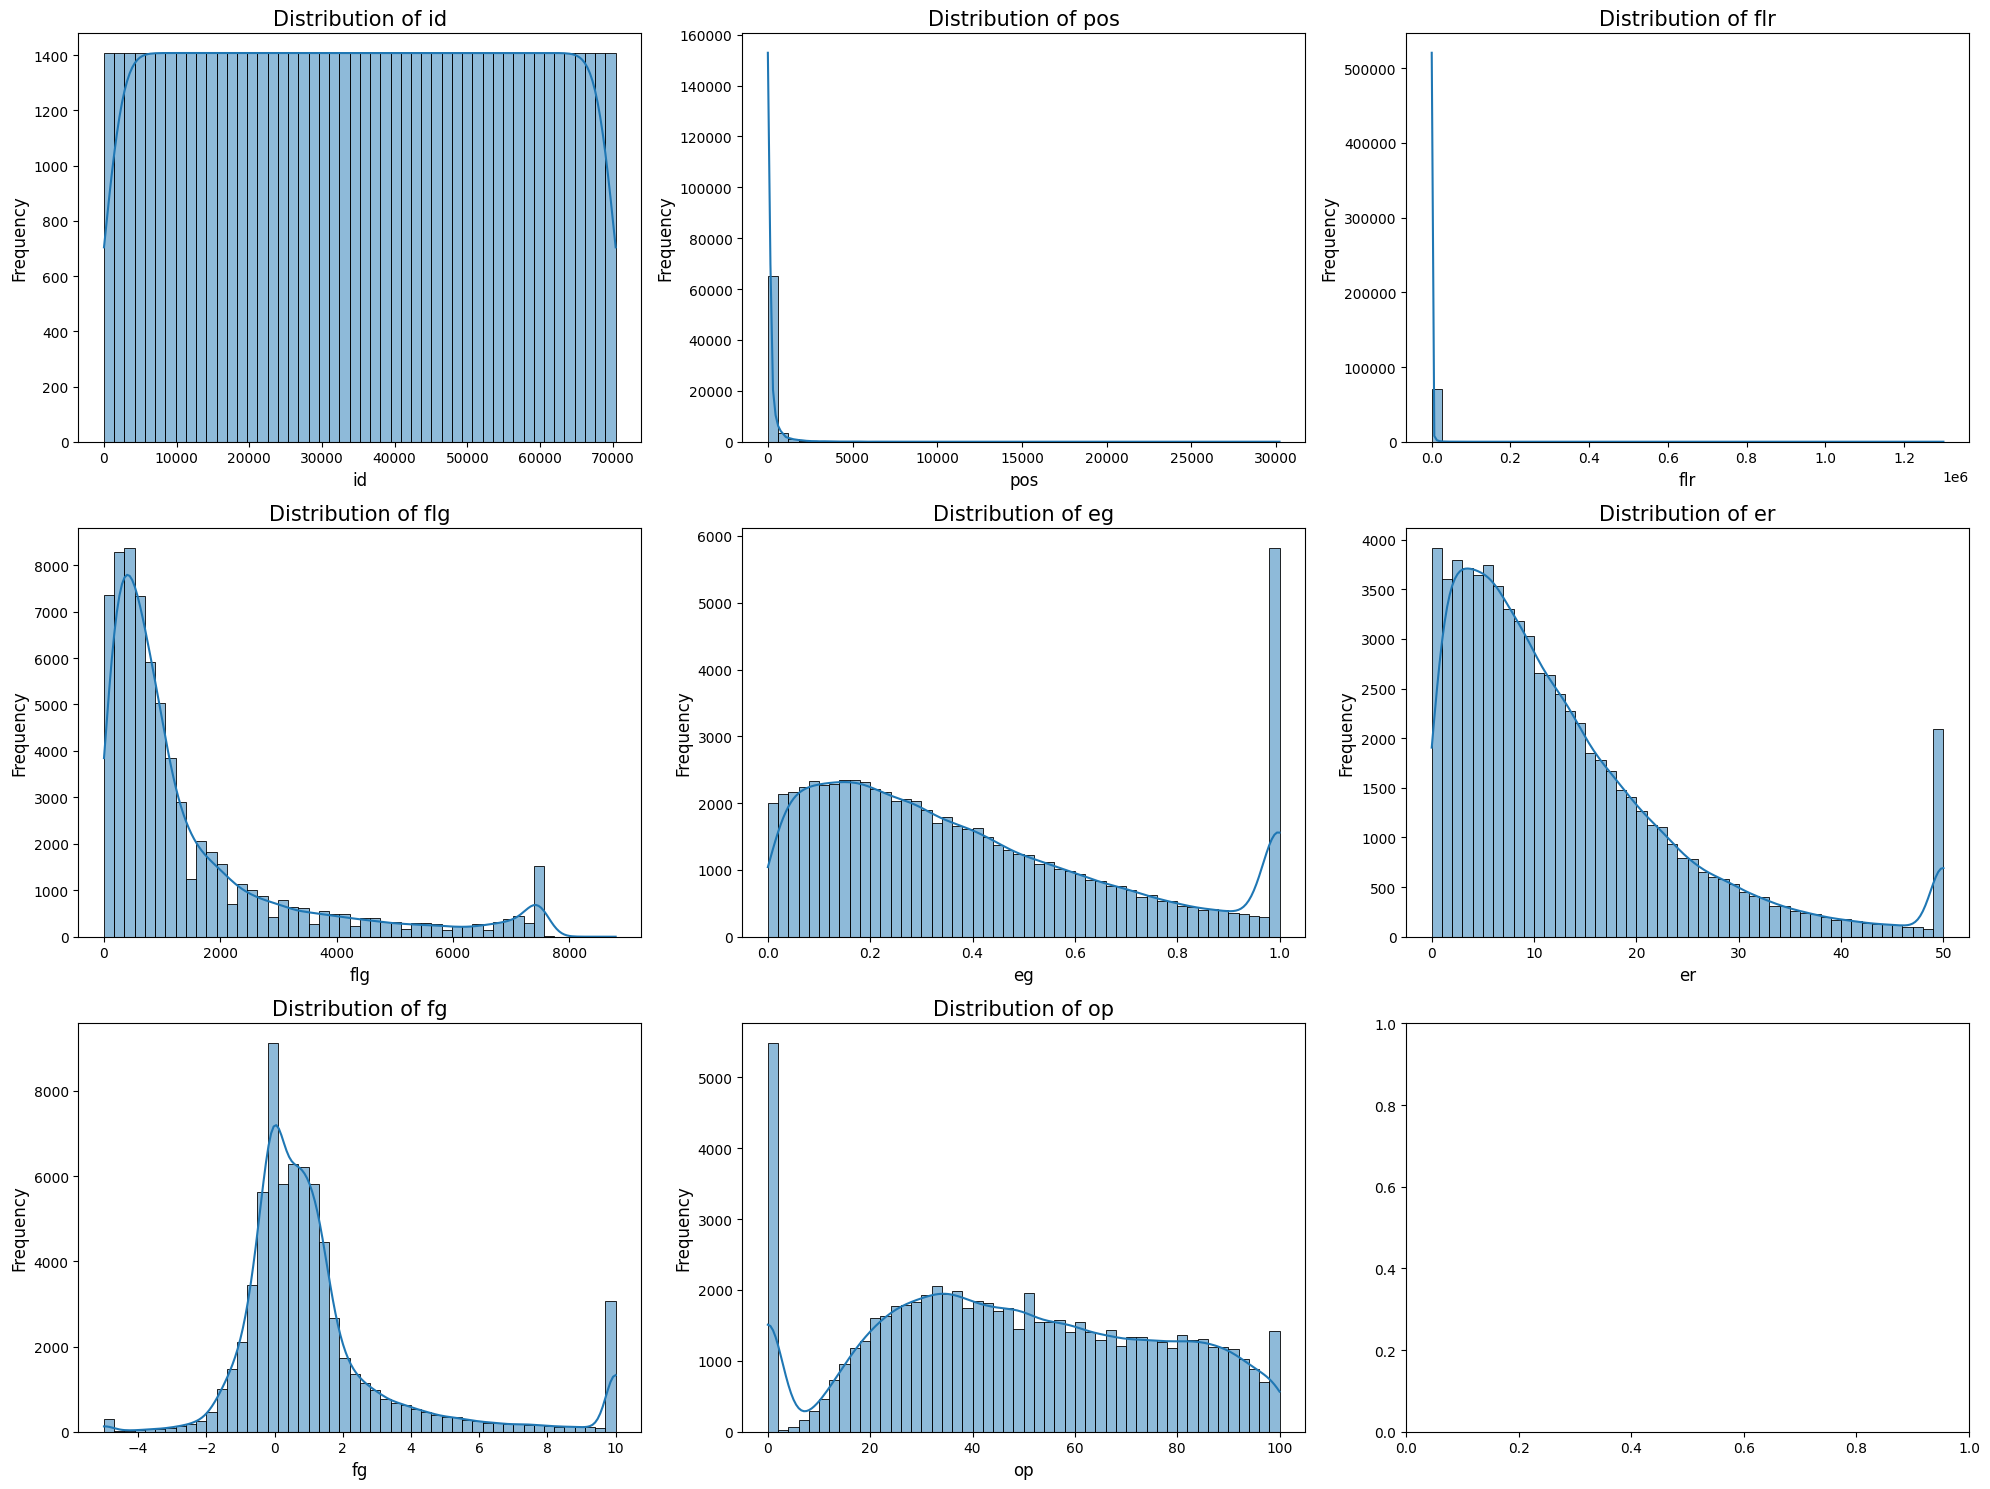

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure and axes
fig, ax = plt.subplots(3, 3, figsize=(20, 15))

# Plot histograms for each column
for i, col in enumerate(data.columns):
    sns.histplot(data[col], ax=ax[i//3, i%3], bins=50, kde=True)
    ax[i//3, i%3].set_title(f'Distribution of {col}', fontsize=15)
    ax[i//3, i%3].set_xlabel(col, fontsize=12)
    ax[i//3, i%3].set_ylabel('Frequency', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


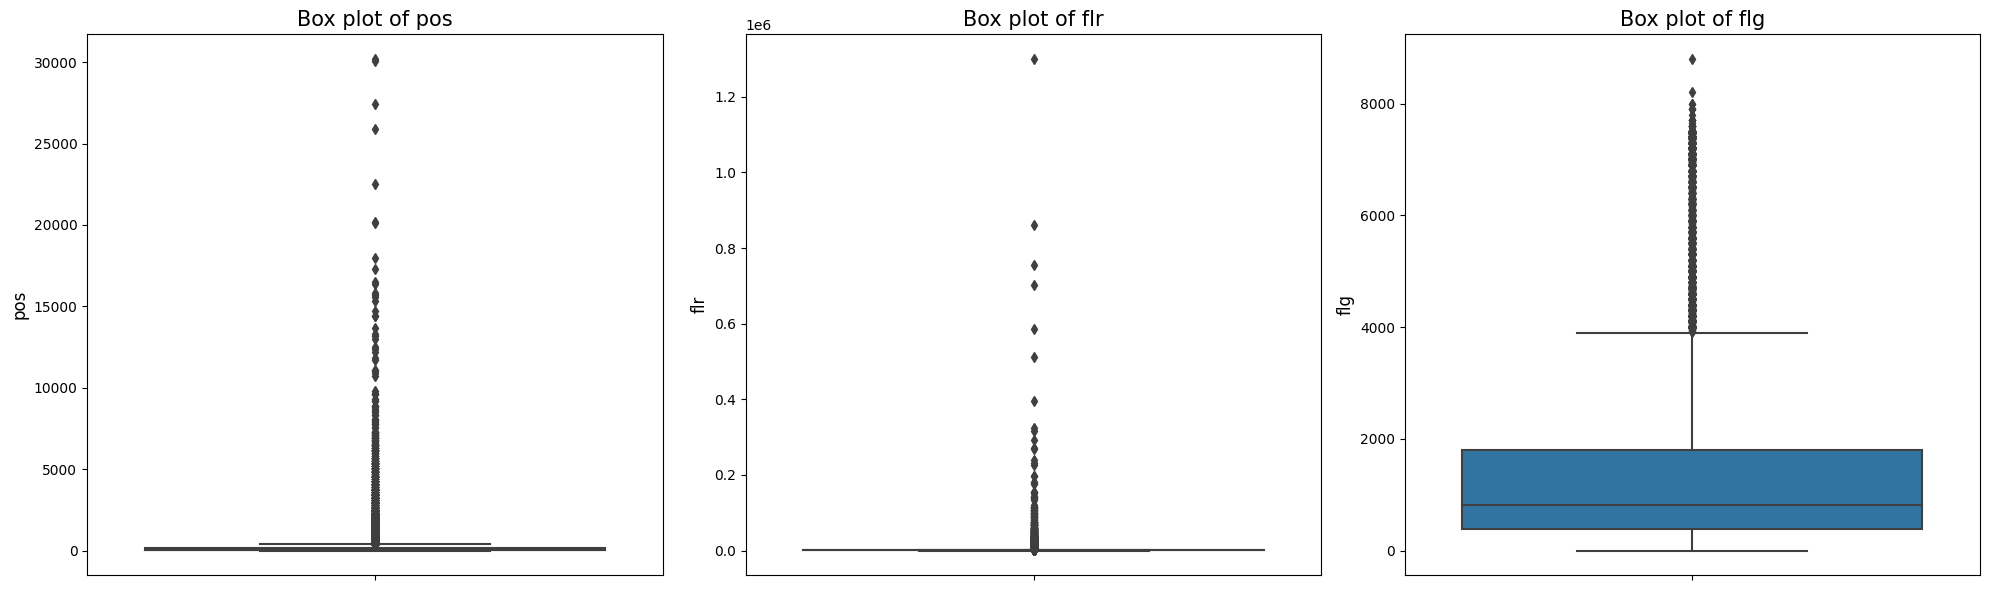

In [6]:
# Columns to visualize with box plots
cols_to_visualize = ['pos', 'flr', 'flg']

# Set up the figure and axes
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Plot boxplots for each specified column
for i, col in enumerate(cols_to_visualize):
    sns.boxplot(y=data[col], ax=ax[i])
    ax[i].set_title(f'Box plot of {col}', fontsize=15)
    ax[i].set_ylabel(col, fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


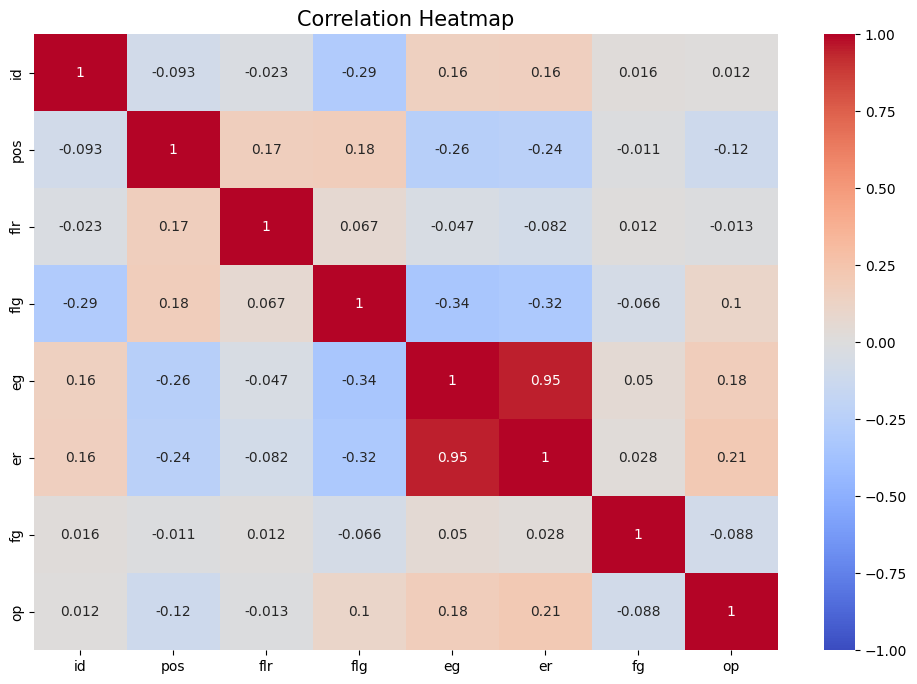

In [8]:
# Compute the correlation matrix
correlation_matrix = data.corr()

# Plot a heatmap to visualize the correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap', fontsize=15)
plt.show()


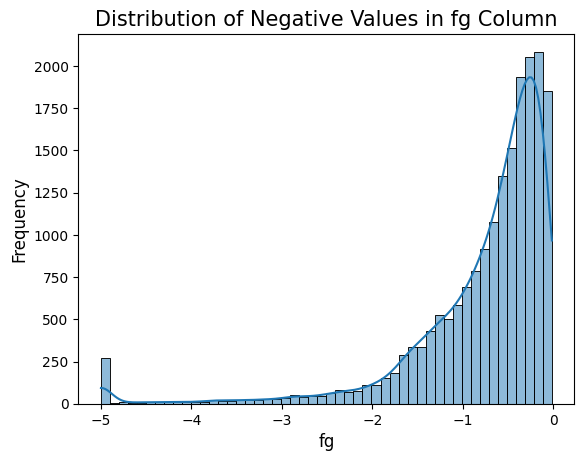

count    18886.000000
mean        -0.775053
std          0.841892
min         -5.000000
25%         -1.003772
50%         -0.515996
75%         -0.255275
max         -0.017544
Name: fg, dtype: float64

In [9]:
# Filter rows where 'fg' column has negative values
negative_fg = data[data['fg'] < 0]

# Display the summary statistics and distribution of negative values in 'fg' column
negative_fg_summary = negative_fg['fg'].describe()
negative_fg_hist = sns.histplot(negative_fg['fg'], bins=50, kde=True)
plt.title('Distribution of Negative Values in fg Column', fontsize=15)
plt.xlabel('fg', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

negative_fg_summary


In [12]:
# ...

# Define columns that need transformation
cols_to_transform = ['pos', 'flr', 'flg', 'fg_shifted']

# Add a constant to make all values in 'fg' column positive
data['fg_shifted'] = data['fg'] + abs(data['fg'].min()) + 1

# Apply log transformation with an added small constant to avoid log(0)
for col in cols_to_transform:
    data[f'{col}_log'] = np.log(data[col] + 0.01)

# Drop the original and shifted columns
data.drop(columns=cols_to_transform, inplace=True)

# Scale the transformed and other columns
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Display the first few rows of the transformed and scaled dataset
data_scaled.head()

# ...


,id,eg,er,fg,op,pos_log,flr_log,flg_log,fg_shifted_log
0,-1.732026,-0.704286,-0.610908,-0.039730,-1.234899,1.523430,0.451802,-0.111781,0.118588
1,-1.731977,-0.684080,-0.594337,-0.458074,-1.158225,0.711467,-0.244805,-0.071119,-0.395736
2,-1.731928,-1.124510,-1.077398,0.371220,-0.378239,1.629119,2.994504,1.221219,0.553249
3,-1.731879,-1.149168,-0.974238,2.456070,0.427844,-0.022863,0.446377,1.775773,2.137724
4,-1.731829,0.398844,0.290039,-0.350462,0.493139,0.072854,-0.056717,1.348242,-0.255195


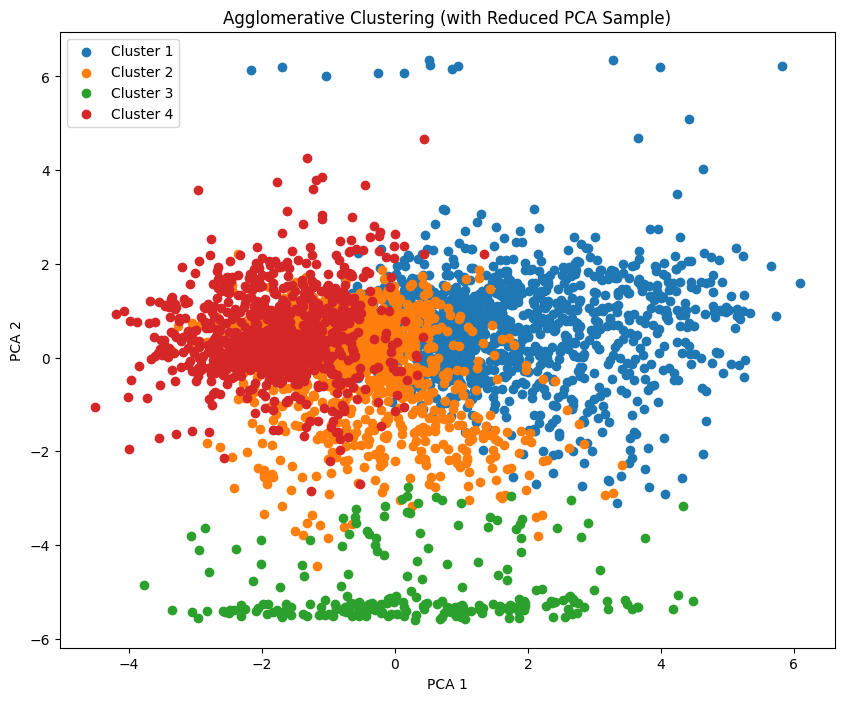

In [16]:
# Reinitialize the PCA instance
pca = PCA(n_components=0.95)

# Scale the transformed and other columns
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Reduce the sample size (taking 5% of the data)
sample_data_reduced = data_scaled.sample(frac=0.05, random_state=0)

# Apply PCA on the reduced sample
data_pca_reduced = pca.fit_transform(sample_data_reduced)

# Apply Agglomerative Clustering on the reduced PCA-transformed sample
agg_cluster = AgglomerativeClustering(n_clusters=4)
cluster_labels = agg_cluster.fit_predict(data_pca_reduced)

# Visualize the clusters using a scatter plot
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.scatter(data_pca_reduced[cluster_labels == i, 0],
                data_pca_reduced[cluster_labels == i, 1],
                label=f'Cluster {i+1}')
plt.title('Agglomerative Clustering (with Reduced PCA Sample)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()


In [17]:
# Recreate the modeling_data dataframe
modeling_data = pd.DataFrame(data_pca_reduced, columns=[f"PCA_{i+1}" for i in range(data_pca_reduced.shape[1])])
modeling_data['Cluster'] = cluster_labels

# Split the data into training and testing sets (80% train, 20% test)
X = modeling_data.drop('Cluster', axis=1)
y = modeling_data['Cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train.shape, X_test.shape


((2816, 6), (704, 6))

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize and train the Logistic Regression classifier
logreg = LogisticRegression(max_iter=1000, random_state=123)
logreg.fit(X_train, y_train)

# Predict on the test set
logreg_preds = logreg.predict(X_test)

# Evaluate the performance
logreg_accuracy = accuracy_score(y_test, logreg_preds)
logreg_accuracy


0.8451704545454546

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=123)
rf.fit(X_train, y_train)

# Predict on the test set
rf_preds = rf.predict(X_test)

# Evaluate the performance
rf_accuracy = accuracy_score(y_test, rf_preds)
rf_accuracy


0.9076704545454546

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train the Gradient Boosting classifier
gb = GradientBoostingClassifier(n_estimators=100, random_state=123)
gb.fit(X_train, y_train)

# Predict on the test set
gb_preds = gb.predict(X_test)

# Evaluate the performance
gb_accuracy = accuracy_score(y_test, gb_preds)
gb_accuracy


0.8920454545454546

In [21]:
from sklearn.ensemble import VotingClassifier

# Create a Voting Classifier using the three trained models
voting_clf = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('rf', rf),
    ('gb', gb)
], voting='hard')

# Train the ensemble on the training data
voting_clf.fit(X_train, y_train)

# Predict on the test set
voting_preds = voting_clf.predict(X_test)

# Evaluate the performance of the ensemble
voting_accuracy = accuracy_score(y_test, voting_preds)
voting_accuracy


0.8963068181818182